# Lecture 20: Chebyshev methods

In [1]:
using Interact

using PyPlot
PyPlot.svg(true);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14182706188656717460\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10453239005570942864\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/ea8282a8d723f49a68b1d36bce2394d3b9f3b531-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-14182706188656717460\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Chebyshev differentiation

Let's assume that we know the Chebyshev transform of a function,

$$
f(x) \approx \sum_{n=0}^N C_n\, T_n(x),
$$

where $T_n(x)$ is the n'th Chebyshev polynomial, and

$$
C_n = \frac{2}{\pi} \int_{-1}^1 \frac{f(x)\, T_n(x)}{\sqrt{1 - x^2}} dx.
$$

Then we can construct numerical *derivatives* by simply differentiating $T_n(x)$.
It turns out that

$$
T'_n(x) = n\sum_{k=0}^{\lfloor{n/2}\rfloor} {{n}\choose{2k+1}} (x^2 -1)^k x^{n-1-2k}.
$$

In [3]:
function chebyshev_basis(n)
    """ Return the n+1 first Chebyshev polynomials
    """
    chebs = Function[x -> 1.0,]
    
    for i=1:n
        function cheb(x)
            f = 0.0
            for k=0:Int64(floor(i/2))
                f += binomial(i, 2k) * (x^2 - 1)^k * x^(i-2k)
            end
            
            return f
        end
        
        push!(chebs, cheb)
    end
    
    return chebs
end

function chebyshev_prime_basis(n)
    """ Return the derivatives of the n+1 first Chebyshev polynomials
    """
    chebs = Function[x -> 0.0,]
    
    for i=0:n-1
        function cheb(x)
            f = 0.0
            for k=0:Int64(floor(i/2))
                f += (i+1)*binomial(i+1, 2k+1) * (x^2 - 1)^k * x^(i-2k)
            end
            
            return f
        end
        
        push!(chebs, cheb)
    end
    
    return chebs
end

function clenshaw_curtis(f, N)
    """ Naive implementation of Clenshaw-Curtis
    using the trapezoid rule for the Fourier coefficients.
    
    Because we want to use this for the Chebyshev transform,
    we set the first and last point to zero to avoid the removable singularity (which is zero).
    """     
    # compute even Fourier coefficients
    a = zeros(N+1)
    
    θs = collect(0:N).*π./N
    ts = cos.(θs)
    fts = f.(ts)
    
    # Trapezoid rule approximation for the even Fourier coefficients
    for ν=1:2:N+1
        a[ν] = (2/N)*sum(fts[2:N].*cos.((ν-1)*θs[2:N]))
    end
    
    # compute integral
    I = a[1]
    for ν=3:N+1
        I += 2a[ν]/(1 - (ν-1)^2)
    end
    
    return I
end

function chebyshev_transform(f, N; N_int=1000)
    """ Compute the Chebyshev transform {C_0, …, C_N} of the 
    function f: [-1, 1] → IR.
    """
    C = zeros(N+1)
    T = chebyshev_basis(N+1)
    
    for i=1:N+1
        C[i] = (2/π)*clenshaw_curtis(x -> f(x)*T[i](x)/sqrt(1 - x^2), N_int) 
    end
    
    # fix constant term
    C[1] /= 2
    
    return C
end

chebyshev_transform (generic function with 1 method)

In [8]:
fun(x) = sqrt(1 + x)* exp(sin(π*x))

N = 15
C = chebyshev_transform(fun, N)

16-element Array{Float64,1}:
  1.266981589257875     
  1.250103585665473     
 -0.30100820827282604   
 -0.7702636187718461    
 -0.3562515627212903    
  0.1619096253273641    
  0.16780831019010767   
  0.05315420457321361   
 -0.05314977156303927   
 -0.026067293916566394  
 -0.006846867768187882  
  0.011434996782095138  
 -0.0013018397923671259 
  0.000309686836270235  
 -0.005191171095051714  
  0.00041867013446586856

In [9]:
xs = LinRange(-1, 1, 500)

fig, ax = subplots()

xs = LinRange(-1, 1, 500)
fxs = fun.(xs)

@manipulate for N=slider(1:30, value=1, label="N")
    withfig(fig, clear=false) do
        
        # Compute Chebyshev transform
        C = chebyshev_transform(fun, N)
        T = chebyshev_basis(N)
        f_cheb(x) = sum(C[i]*T[i](x) for i=1:length(C))
        
        # Plot interpolant
        ax.cla()

        ax.plot(xs, fun.(xs), label=L"function $f(x) = \sqrt{1+x}e^{\sin\pi x}$")
        ax.plot(xs, f_cheb.(xs), label="N=$(N) Chebyshev transform interpolant")

        ax.set_xlabel(L"x")
        ax.set_ylabel(L"f(x)")
        ax.legend()
        
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope("knockout-component-fe3e8592-265d-47b3-a800-6ad373f4c737", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["N"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row-left"), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>30,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-center"), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/henrik/.julia/packages/Knockout/JE2Yq/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/henrik/.julia/packages/Knockout/JE2Yq/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/henrik/.julia/packages/InteractBase/R8JgH/src/../assets/all.js"), Asset("css", nothing, "/home/henrik/.julia/packages/InteractBase/R8JgH/src/../assets/style.css"), Asset("css", nothing, "/home/henrik/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"knockout-component-fe3e8592-265d-47b3-a800-6ad373f4c737\",\"id\":\"ob_02\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"knockout-component-fe3e8592-265d-47b3-a800-6ad373f4c737\",\"id\":\"ob_01\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel

In [10]:
xs = LinRange(-1, 1, 500)

fig, ax = subplots()

xs = LinRange(-1, 1, 500)

fun_prime(x) = exp(sin(π*x))/(2sqrt(1+x)) + exp(sin(π*x))*π*sqrt(1+x)*cos(π*x)

@manipulate for N=slider(1:30, value=1, label="N")
    withfig(fig, clear=false) do
        
        # Compute Chebyshev transform
        C = chebyshev_transform(fun, N)
        Tprime = chebyshev_prime_basis(N)
        f_cheb(x) = sum(C[i]*Tprime[i](x) for i=1:length(C))
        
        # Plot interpolant
        ax.cla()

        ax.plot(xs, fun_prime.(xs), label=L"$f'(x)$")
        ax.plot(xs, f_cheb.(xs), label="N=$(N) Chebyshev transform derivative")

        ax.set_xlabel(L"x")
        ax.set_ylabel(L"f'(x)")
        ax.legend()
        
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope("knockout-component-c1f559ea-8dc8-4136-98c4-209f8744ac8e", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["N"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row-left"), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>30,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-center"), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/henrik/.julia/packages/Knockout/JE2Yq/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/henrik/.julia/packages/Knockout/JE2Yq/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/henrik/.julia/packages/InteractBase/R8JgH/src/../assets/all.js"), Asset("css", nothing, "/home/henrik/.julia/packages/InteractBase/R8JgH/src/../assets/style.css"), Asset("css", nothing, "/home/henrik/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"knockout-component-c1f559ea-8dc8-4136-98c4-209f8744ac8e\",\"id\":\"ob_10\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"knockout-component-c1f559ea-8dc8-4136-98c4-209f8744ac8e\",\"id\":\"ob_09\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel

## ApproxFun

Chebyshev methods (and more) are implemented in Julia in the ApproxFun package, which
allows you to use basic operations with Chebyshev approximants.

In [2]:
using ApproxFun

In [11]:
# identity function on [0, 10]
x = Fun(identity, 0..10)

# These are Chebyshev approximants
f = sin(x^2)
g = cos(x)

Fun(Chebyshev(0..10),[-0.0503775, -0.628247, -0.0264175, -0.699691, 0.221956, 0.500828, -0.0743471, -0.102368, 0.0104417, 0.0105871  …  -4.18633e-10, 1.57168e-11, 6.41294e-12, -2.18299e-13, -8.1142e-14, 2.52688e-15, 8.62578e-16, -2.47455e-17, -7.54865e-18, -2.0554e-19])

In [12]:
# our transform on [0, 10]. Coefficients match!
chebyshev_transform(x->cos( 5(x+1) ), 5)

6-element Array{Float64,1}:
 -0.05046122549248906 
 -0.6263332915467504  
 -0.026584999631168012
 -0.69777716613667    
  0.221788178717677   
  0.5027418937356725  

In [13]:
# compose functions
h = f + g^2

Fun(Chebyshev(0..10),[0.637381, -0.17556, 0.194687, -0.0810387, 0.00424572, -0.0569495, -0.212969, -0.131291, -0.293394, -0.0230951  …  -9.85948e-16, -3.8132e-16, 2.77316e-18, 7.06597e-17, 3.22827e-17, 2.3578e-18, -4.51364e-18, -2.28146e-18, -1.17196e-19, -2.42213e-19])

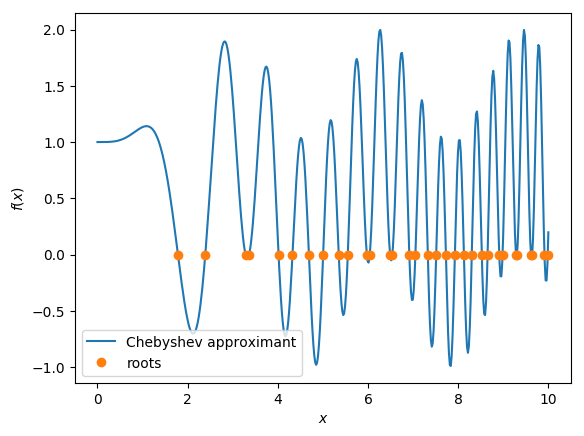

PyObject <matplotlib.legend.Legend object at 0x7f121189db00>

In [14]:
# find roots
r = roots(h)

figure()
xs = LinRange(0, 10, 500)

plot(xs, h.(xs), label="Chebyshev approximant")
plot(r, [0.0 for i=1:length(r)], "o", label="roots")

xlabel(L"x")
ylabel(L"f(x)")
legend()

In [16]:
# Solving boundary value problems

x = Fun(identity, 0..10)
D = Derivative()
B = Dirichlet() # Boundary conditions f(-1000), f(200) fixed
L = D^2 - x # Differential operator: (d^2/dx^2 - x)

h = cos(x)

u = [B; L] \ [[1, 2], h] # u solves B*u = [1, 2] and L*u = h

Fun(Chebyshev(0..10),[0.393825, 0.0962241, 0.578835, 0.23377, 0.293624, 0.0385286, 0.173627, 0.0868447, 0.0390192, 0.0329215  …  3.24327e-13, 8.38354e-14, 2.12601e-14, 5.28615e-15, 1.29083e-15, 3.09564e-16, 7.28863e-17, 1.68228e-17, 3.86786e-18, -8.61999e-19])

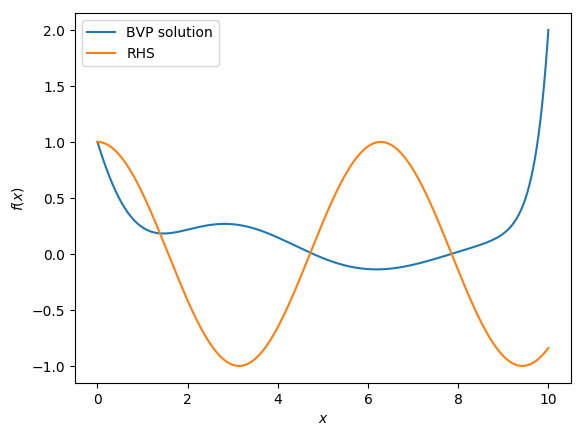

PyObject <matplotlib.legend.Legend object at 0x7f12920bc7b8>

In [17]:
figure()

xs = LinRange(0, 10, 500)

plot(xs, u.(xs), label="BVP solution")
plot(xs, h.(xs), label="RHS")

xlabel(L"x")
ylabel(L"f(x)")
legend()